In [136]:
import datasets
#!pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
#!pip install gensim
from gensim.utils import tokenize
import random
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
import re
import matplotlib.pyplot as plt

#import matplotlib
#from collections import Counter


In [44]:
#Only 18691 are from before the current AY
dataset = pd.read_csv('/Users/wjrowesr/Library/CloudStorage/OneDrive-KennesawStateUniversity/Writing Center/Data Projects/WC10yrML_1203.csv')
#Get College Guess into a single string, don't need to have individual nodes for each word
dataset['college_guess'] = dataset['college']
dataset['appts_yr1'] = dataset['num_appts']

dataset['college_guess'] = dataset['college_guess'].str.replace(' ', '', regex=False)
dataset['college_guess'] = dataset['college_guess'].str.replace('.', '', regex=False)
dataset['college_guess'] = dataset['college_guess'].str.replace('-', '', regex=False)
dataset['appts_yr1'].describe(include='all')

#Remove any NA values with empty strings in the string variables
dataset['code'] = dataset['code'].fillna('')
dataset['code'] =dataset['code'].astype(str).str.replace(r"\d", "", regex=True)
dataset['num'] = round(pd.to_numeric(dataset['num'].fillna('-1000'), errors = 'coerce'),-3)
dataset['num'] = dataset['num'].fillna(-1000)

dataset['age'] = dataset['age'].fillna('') 
dataset['campus'] = dataset['campus'].fillna('') 
dataset['college_guess'] = dataset['college_guess'].fillna('') 

#Fix format of off-schedule variable
dataset['off_sched'].iloc[dataset['off_sched'].isna()] = 0

#Remove NA values for h
dataset = dataset[dataset['h'].notna()]


dataset = dataset.sort_values(by='AY', ascending = False)



/var/folders/37/jp4rz821145__r5hpr2c96m80000gn/T/ipykernel_69213/3568747726.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['off_sched'].iloc[dataset['off_sched'].isna()] = 0
/var/folders/37/jp4rz821145__r5hpr2c96m80000gn/T/ipyk

In [45]:
#dataset.head(-1000)
#dataset['code'].value_counts(dropna = False)
#dataset.info()
dataset['AY'].head(-1000)


35128    2025
34947    2025
34975    2025
34974    2025
34973    2025
         ... 
551      2011
552      2011
553      2011
554      2011
555      2011
Name: AY, Length: 34100, dtype: int64

In [218]:
predict_dataset = dataset[dataset['AY'] ==2024]
train_dataset = dataset[dataset['AY'] <= 2020]
train_dataset.head()

print(train_dataset.info())
train_dataset['off_sched'].value_counts()
train_dataset['appts_yr1'].describe()

<class 'pandas.core.frame.DataFrame'>
Index: 21266 entries, 20061 to 0
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        21266 non-null  int64  
 1   X                 21266 non-null  int64  
 2   email             21266 non-null  object 
 3   num_appts2011     1292 non-null   float64
 4   num_appts2012     2070 non-null   float64
 5   num_appts2013     2177 non-null   float64
 6   num_appts2014     2663 non-null   float64
 7   num_appts2015     3112 non-null   float64
 8   num_appts2016     3445 non-null   float64
 9   num_appts2017     3260 non-null   float64
 10  num_appts2018     3497 non-null   float64
 11  num_appts2019     3223 non-null   float64
 12  num_appts2020     2408 non-null   float64
 13  num_appts2021     727 non-null    float64
 14  num_appts2022     414 non-null    float64
 15  num_appts2023     218 non-null    float64
 16  num_appts2024     119 non-null    float64
 17

count    21266.000000
mean         3.246638
std          8.716075
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        563.000000
Name: appts_yr1, dtype: float64

In [219]:
#Split data set
#Another way to do it
# Remove validation indices from the test pool
#remaining_test_indices = list(set(all_test_indices) - set(random_indices_valid))


#College,
#Course, Code?
#Length, h, day, week, num_appts_yr1

#age 
#campus


# Randomly sample 20000 indices for training, remainder for for test (11000)
random_indices_train = random.sample(range(len(train_dataset)), 10000)
stock = list(range(len(train_dataset)))
indices_not_in = [val for i, val in enumerate(stock) if val not in random_indices_train]


# Use the random indices to select data
train_data_final = train_dataset.iloc[random_indices_train]
test_data_final = train_dataset.iloc[indices_not_in]

# test_data_text = [test_dataset[i]['text'] for i in random_indices_test]
# test_data_labels = [test_dataset[i]['label'] for i in random_indices_test]

#Create labels to indicate if students were "retained" additional years
train_data_final['ret'] = np.where(train_data_final['retention_yrs']>1, 1,0)
train_data_labels = train_data_final['ret'].values.tolist()

test_data_final['ret'] = np.where(test_data_final['retention_yrs']>1, 1,0)
test_data_labels = test_data_final['ret'].values.tolist()

#Oversample to get equal instances of retained students
ros = RandomOverSampler(random_state=42)
#print('OG dataset shape %s' % Counter(train_data_labels))
X_res, y_res = ros.fit_resample(train_data_final, train_data_labels)
#print('Resampled dataset shape %s' % Counter(y_res))

/var/folders/37/jp4rz821145__r5hpr2c96m80000gn/T/ipykernel_69213/1904695338.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_final['ret'] = np.where(train_data_final['retention_yrs']>1, 1,0)
/var/folders/37/jp4rz821145__r5hpr2c96m80000gn/T/ipykernel_69213/1904695338.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_final['ret'] = np.where(test_data_final['retention_yrs']>1, 1,0)


In [221]:
#use gensim's text tokenizer
def tokenize_text(example):
    tokens = list(tokenize(example))
    return {"tokens": tokens}

output = tokenize_text('SouthernPolytechnicCollegeofEngineeringandEngineeringTechnology')
output

{'tokens': ['SouthernPolytechnicCollegeofEngineeringandEngineeringTechnology']}

In [222]:
#Get each variable in numerical form

#Do the same thing for the different college types

#First, turn Course Codes into a vocab dictionary
#Concatenate code and num into single entry
X_res['code'] = X_res['code'].astype(str)

vocab = {}
idx = 0
for index, ex in X_res.iterrows():
  for word in tokenize_text(ex['code'])['tokens']:
    if word not in vocab:
      vocab[word] = idx
      idx += 1

  if ex['college_guess'] not in vocab:
      vocab[ex['college_guess']] = idx
      idx += 1
  if ex['age'] not in vocab:
      vocab[ex['age']] = idx
      idx += 1

  if ex['campus'] not in vocab:
      vocab[ex['campus']] = idx
      idx += 1

len(vocab) #important as we determine the number of values in the first linear layer
#X_res['college'].value_counts()

572

In [223]:
#Create List of all character input information as a list of strings
train_data_list = []
test_data_list = []

for index, ex in X_res.iterrows():
    entry = str(ex['code']) + ' ' + str(ex['college_guess']) + ' ' + str(ex['age']) + ' ' + str(ex['campus'] )
    # entry = entry.extend(ex['college'].tolist())
    #print(entry)
    train_data_list.append(entry)

for index, ex in test_data_final.iterrows():
    entry = str(ex['code']) + ' ' + str(ex['college_guess']) + ' ' + str(ex['age']) + ' ' + str(ex['campus'] )
    test_data_list.append(entry)

print(len(train_data_list))
print(len(test_data_list))

#Course Code
# train_data_list =  X_res['code2'].values.astype(str).tolist()
# test_data_list =  test_data_final['code2'].values.astype(str).tolist()

# #College 
# college_list = X_res['college'].values.astype(str).tolist()
# test_college_list =  test_data_final['college'].values.astype(str).tolist()



15136
11266


In [224]:
# Convert text to numerical representation (bag of words) + college indicator
#Should be pretty easy to modify the text_to_box function to include numerical data at the end of the bow vec

def text_to_bow(text, vocab):
  bow_vector = torch.zeros(len(vocab))
  for word in tokenize_text(text)['tokens']:
    if word in vocab:
      bow_vector[vocab[word]] = 1
  return bow_vector

# Create PyTorch dataset for training data
X_train = torch.stack([text_to_bow(example, vocab) for example in train_data_list])

#Add non text numerical data such as length, num_appts_yr1, and flags
num_cols = X_res[['day', 'week', 'h','yr', 'num', 'length', 'appts_yr1', 'off_sched']] #, 'yr2_flag', 'yr3_flag', 'yr4_flag']]
num_tensor = torch.tensor(num_cols.values, dtype=torch.float32)

X_train = torch.cat((X_train, num_tensor), dim =1)
y_train = torch.tensor(y_res)


# Create PyTorch dataset for test data

X_test = torch.stack([text_to_bow(example, vocab) for example in test_data_list])

#Add non text numerical data such as length, num_appts_yr1, and flags
num_cols = test_data_final[['day', 'week', 'h','yr', 'num', 'length', 'appts_yr1','off_sched']] #'yr2_flag', 'yr3_flag', 'yr4_flag']]
num_tensor = torch.tensor(num_cols.values, dtype=torch.float32)

X_test = torch.cat((X_test, num_tensor), dim =1)

y_test = torch.tensor(test_data_labels)


train_dataset_tensor = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset_tensor, batch_size=32, shuffle=True)

In [225]:
class SimpleNN(nn.Module):
  def __init__(self, vocab_length):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(vocab_length, 200)  # Input layer
    self.fc2 = nn.Linear(200, 2) # First hidden layer
    self.relu = nn.ReLU() # Activation function
    #self.fc3 = nn.Linear(100, 2)  # Second hidden layer outputs 2 neurons (for 2 classes, positive or negative)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.relu(self.fc1(x))  # Input -> Hidden layer 1
    #x = self.relu(self.fc2(x))  # Hidden layer 1 -> Hidden layer 2
    x = self.fc2(x)             # Hidden layer 1 -> Output layer
    #x = self.softmax(x)         # Apply softmax activation
    return x

In [226]:
# class baseNN(nn.Module):
#   def __init__(self, vocab_length):
#     super(baseNN, self).__init__()
#     self.fc1 = nn.Linear(vocab_length, 2)  # Input layer
#     self.relu = nn.ReLU() # Activation function
#     self.softmax = nn.Softmax(dim=1)

#   def forward(self, x):
#     x = self.fc1(x)
#     #x = self.relu(self.fc1(x))  # Input -> Hidden layer 1
#     x = self.softmax(x)         # Apply softmax activation
#     return x

In [227]:
model = SimpleNN(len(vocab)+num_cols.shape[1])
#model2 = baseNN(len(vocab)+num_cols.shape[1])

In [228]:
criterion = nn.CrossEntropyLoss()  # Good for multi-class classification
#Means we are summing the total error between predictions and actual value for every example

In [229]:
#optimizer2 = optim.Adam(model2.parameters(), lr=0.005)  # Adam optimizer with a learning rate of 0.005
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.005

In [230]:
# # Train the base model
# num_epochs = 10 # Accuracy somewhat sensitive to random initializations but not really
# for epoch in range(num_epochs):
#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer2.zero_grad()
#         outputs = model2(inputs.float()) # Convert to float32
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     print('Epoch', str(epoch+1),'completed, Loss:', str(loss.item()))

# print("Training finished.")

In [231]:
# with torch.no_grad(): #Disable gradient calculation during prediction
#     model2.eval() # Set the model to evaluation mode
#     outputs = model2(X_test.float()) #Get predictions
#     _, predicted = torch.max(outputs, 1) #get predicted classes

# # Calculate accuracy
# correct_predictions = (predicted == y_test).sum().item()
# accuracy = correct_predictions / len(y_test)

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(outputs[:50])

In [232]:
# Train the multi layer model, not sure it is working very well
num_epochs = 20 # Will try to find early stoping point where accuracy of training set begins to stop
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.float()) # Convert to float32
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('Epoch', str(epoch+1),'completed, Loss:', str(loss.item()))

print("Training finished.")

Epoch 1 completed, Loss: 0.674422025680542
Epoch 2 completed, Loss: 0.5297848582267761
Epoch 3 completed, Loss: 0.9231067299842834
Epoch 4 completed, Loss: 1.1742122173309326
Epoch 5 completed, Loss: 0.5481405854225159
Epoch 6 completed, Loss: 0.5638136267662048
Epoch 7 completed, Loss: 0.4535943269729614
Epoch 8 completed, Loss: 0.789181113243103
Epoch 9 completed, Loss: 0.3836343288421631
Epoch 10 completed, Loss: 0.44549474120140076
Epoch 11 completed, Loss: 0.7449803948402405
Epoch 12 completed, Loss: 0.45452961325645447
Epoch 13 completed, Loss: 0.5349020957946777
Epoch 14 completed, Loss: 0.5994499921798706
Epoch 15 completed, Loss: 0.49106931686401367
Epoch 16 completed, Loss: 0.6625627279281616
Epoch 17 completed, Loss: 0.38142433762550354
Epoch 18 completed, Loss: 0.5820980072021484
Epoch 19 completed, Loss: 0.4014882743358612
Epoch 20 completed, Loss: 0.4727775454521179
Training finished.


In [233]:
with torch.no_grad(): #Disable gradient calculation during prediction
    model.eval() # Set the model to evaluation mode
    outputs = model(X_test.float()).squeeze() #Get predictions
    predicted = torch.sigmoid(outputs) #get predicted classes
    pred_class = predicted[:,1] > 0.5

# Calculate accuracy
correct_predictions = (pred_class == y_test).sum().item()
accuracy = correct_predictions / len(y_test)

pred_true = pred_class[y_test ==1]
test_true = y_test[y_test ==1]

correct_true = (pred_true == test_true).sum().item()
true_accuracy = correct_true / len(test_true)

pred_false = pred_class[y_test ==0]
test_false = y_test[y_test ==0]

correct_false = (pred_false == test_false).sum().item()
false_accuracy = correct_false / len(test_false)


print(f"Test Accuracy: {accuracy * 100:.2f}%", true_accuracy, false_accuracy)
print(predicted, )

Test Accuracy: 82.82% 0.5260574018126888 0.9209793455558134
tensor([[0.4134, 0.3549],
        [0.0328, 0.5357],
        [0.1466, 0.6138],
        ...,
        [0.0405, 0.5215],
        [0.4375, 0.3297],
        [0.3985, 0.3523]])


In [68]:
#Oversampled model has a lower accuracy, but still above 50% (63.55%)
#Oversampled model with college increased accuracy slightly, now (65.53%)
#With numeric data, accurracy of model has increased to 99.54, maybe the flags are too helpful
#Without flags, we are now at 71.8%   Nice!
#Added campus and age fields, now out accuracy is 71.95%
#Added off-schedule appointments and the off-schedule appointment indicator, accuracy rose to 78.26
#Accuracy of multi-layer model is 63.31% so it is worse

#FINAL CONCLUSIONS
#Accuracy depends on split of test, train, should do k-fold validation
#Ex splits Logistic- 56
#2 layers - 65%
#3 Layers - 59%

# 2 layers helps a bit but 3 layers over fits



#4 Parameters I will play with
#Epochs
#Number of Layers and Nuerons (prefer wide to deep) - best so far seems to be 1
#Training Rate
#Do I include all the variables or just the important ones?



In [158]:
import numpy as np
# Define background size
background_size = 1000

# Randomly sample indices without replacement
indices = torch.randperm(X_train.size(0))[:background_size]

# Subsample for background
background = X_train[indices]

# Convert to NumPy (SHAP needs NumPy arrays for KernelExplainer)
background_np = background.numpy()



In [159]:
import shap
import torch

# model: your trained PyTorch model
# X_tensor: your input as torch tensor

explainer = shap.GradientExplainer(model, background)

indices = torch.randperm(X_test.size(0))[:background_size]

# SHAP values for your input
shap_values = explainer.shap_values(X_test[indices])  # compute for a subset if needed






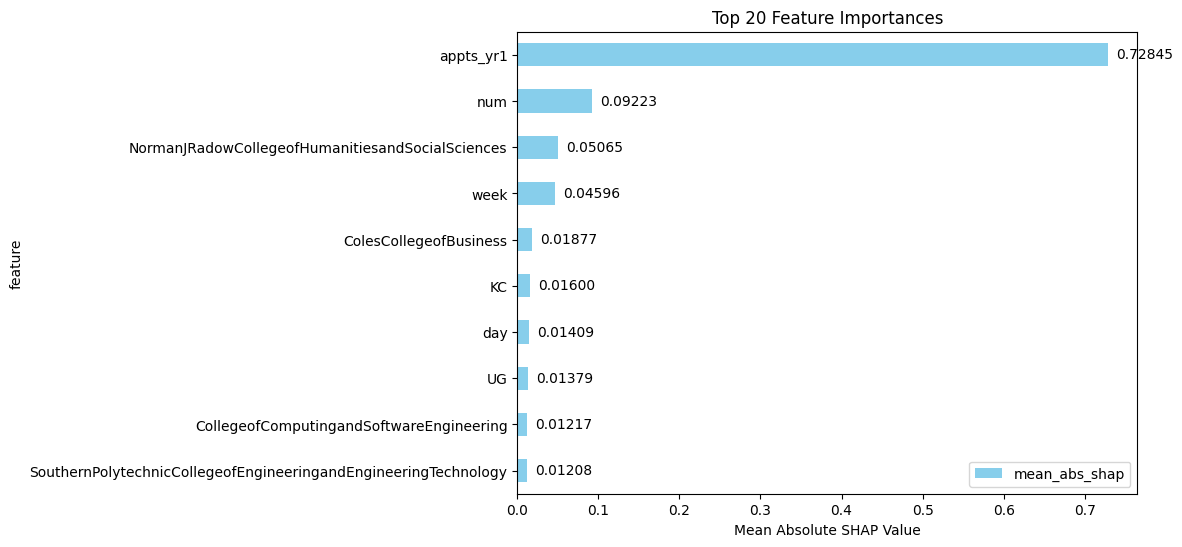

In [189]:
# If X is a DataFrame
names = list(vocab.keys())
names.extend(['day', 'week', 'h',"yr", "num", 'length', 'appts_yr1','off_sched'])
names = [x if x is not None else 'empty' for x in names]
#feature_names = pd.Index(names)

mean_abs_shap = np.abs(shap_values).mean(axis=0)[:,0]
raw_shap = shap_values.mean(axis=0)[:,0]


# Create a DataFrame
shap_df = pd.DataFrame({
    "feature": names,
    "mean_abs_shap": mean_abs_shap,
    "raw_shap" : raw_shap
})

# Select top 20 features
top20 = shap_df.sort_values("mean_abs_shap", ascending=False).head(10)

# Plot
top20.plot.barh(x="feature", y="mean_abs_shap", color="skyblue", figsize=(8,6))
plt.gca().invert_yaxis()  # largest on top
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 20 Feature Importances")
for i, v in enumerate(top20["mean_abs_shap"]):
    plt.text(v + 0.01, i, f"{v:.5f}", va='center')

#plt.show()
plt.savefig("SHAP.png", dpi=300, bbox_inches="tight")


/var/folders/37/jp4rz821145__r5hpr2c96m80000gn/T/ipykernel_69213/1666261709.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], X_test[indices],show=False)


(-0.2, 0.2)

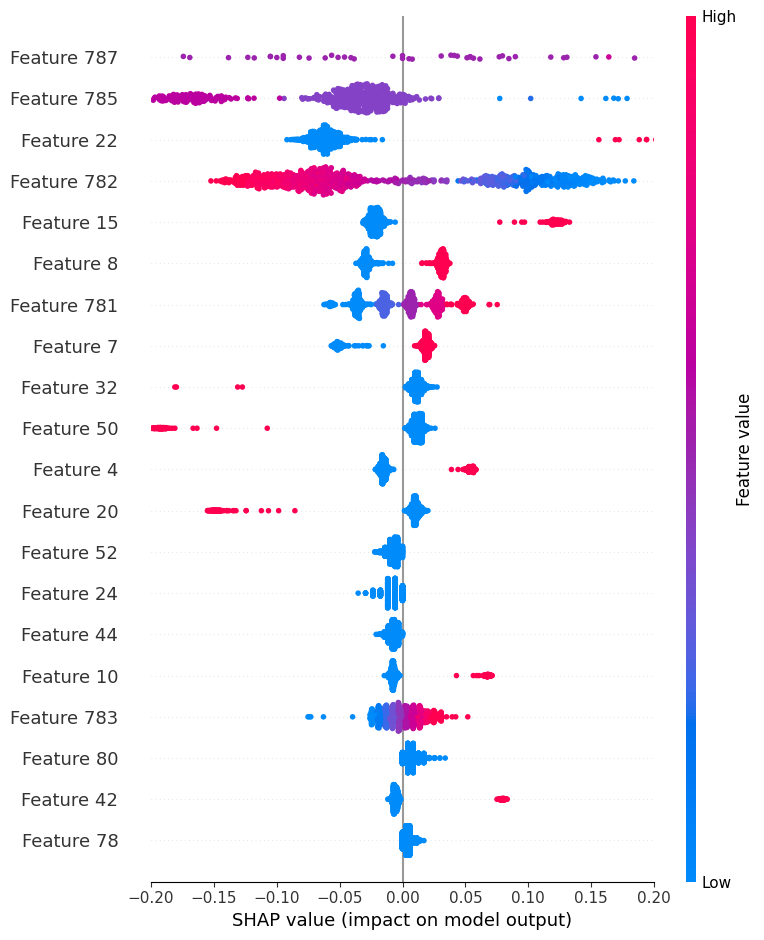

In [186]:
shap.summary_plot(shap_values[:,:,1], X_test[indices],show=False)
plt.xlim(-.2, 0.2)

In [234]:
#Apply this to last years students
predict_data_list = []

for index, ex in predict_dataset.iterrows():
    entry = str(ex['code']) + ' ' + str(ex['college_guess']) + ' ' + str(ex['age']) + ' ' + str(ex['campus']) 
    predict_data_list.append(entry)

print(len(predict_data_list))

# Create PyTorch dataset for training data
predict_torch = torch.stack([text_to_bow(example, vocab) for example in predict_data_list])

#Add non text numerical data such as length, num_appts_yr1, and flags
num_cols = predict_dataset[['day', 'week', 'h','yr', 'num', 'length', 'appts_yr1', 'off_sched']] #, 'yr2_flag', 'yr3_flag', 'yr4_flag']]
num_tensor = torch.tensor(num_cols.values, dtype=torch.float32)

predict_torch = torch.cat((predict_torch, num_tensor), dim =1)

with torch.no_grad(): #Disable gradient calculation during prediction
    model.eval() # Set the model to evaluation mode
    outputs = model(predict_torch.float()) #Get predictions
    predicted = torch.sigmoid(outputs) #get predicted classes
    pred_class = predicted[:,1] > 0.5


3338


In [252]:


df2 = predict_dataset.reset_index()
df2['group'] = pred_class.numpy()
df2['group'] = df2['group'].astype(int)
final_df = df2.sort_values(by = 'group', ascending = False)

In [255]:
to_print = final_df[['email','college_guess','appts_yr1', 'num','week']]
to_print.to_excel("/Users/wjrowesr/Library/CloudStorage/OneDrive-KennesawStateUniversity/Writing Center/WC_NN/email_list.xlsx", index = False)